[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zain2525//Computer-Vision-with-transfer-learning/blob/main/Food_Vision.ipynb)

# Food Vision 101™ 🍔👁
## Transfer Learning With TenserFlow (Feature Extraction & Fine-Tuning):

We're going to be building Food Vision Big™, a transfer learning model which beat the original results of the [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) paper.

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

## What we're going to cover

* Using Kaggel Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model 
* Fine-tuning the feature extraction model


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## Get the data from Kaggel

Download kaggle.json file on your machine that contains (username, key)

Let's install kaggel in Google Colab 

In [2]:
# Install kaggle
!pip install -q kaggle

Now let's upload the json file.

In [ ]:
# Upload kaggle.json file
from google.colab import files
files.upload()

Now let's Create a directory to save the data in

In [4]:
# Create a kaggle folder
!mkdir ~/.kaggle

Now Let's copy the json file to the directory

In [5]:
# Copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

Now, lets allow the jason file to act

In [6]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

Now, it's time to get the data from kaggel

In [7]:
! kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [05:52<00:00, 16.4MB/s]
100% 5.30G/5.30G [05:52<00:00, 16.2MB/s]


### Split the data to (train, validation and test)

First, let's unzip the data.

In [8]:
# Unzip the downloaded file
import zipfile

zip_ref = zipfile.ZipFile("/content/food41.zip")
zip_ref.extractall()
zip_ref.close()

Let's install the splitfolders

In [9]:
# spilt data
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, Let's spilt our data to (train, validation and test) directories

In [10]:
# spilt data to train/val/test
import splitfolders # or import splitfolders
input_folder = "/content/images"
output = "/content/Food_101" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .15, .05)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 101000 files [01:32, 1090.34 files/s]


## Preprocessing the data

In [11]:
train_dir = "/content/Food_101/train/"
val_dir = "/content/Food_101/val/"
test_dir = "/content/Food_101/test/"

### Create function to walk through an image classification directory

In [12]:
# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [13]:
# How many images/classes are there?
walk_through_dir("/content/Food_101")

There are 3 directories and 0 images in '/content/Food_101'.
There are 101 directories and 0 images in '/content/Food_101/train'.
There are 0 directories and 800 images in '/content/Food_101/train/donuts'.
There are 0 directories and 800 images in '/content/Food_101/train/dumplings'.
There are 0 directories and 800 images in '/content/Food_101/train/ramen'.
There are 0 directories and 800 images in '/content/Food_101/train/sashimi'.
There are 0 directories and 800 images in '/content/Food_101/train/eggs_benedict'.
There are 0 directories and 800 images in '/content/Food_101/train/crab_cakes'.
There are 0 directories and 800 images in '/content/Food_101/train/clam_chowder'.
There are 0 directories and 800 images in '/content/Food_101/train/carrot_cake'.
There are 0 directories and 800 images in '/content/Food_101/train/cannoli'.
There are 0 directories and 800 images in '/content/Food_101/train/foie_gras'.
There are 0 directories and 800 images in '/content/Food_101/train/fish_and_chips

In [14]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/Food_101/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

In [15]:
# Let's visualize our images
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Cet a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

['2332465.jpg']
Image shape: (384, 512, 3)


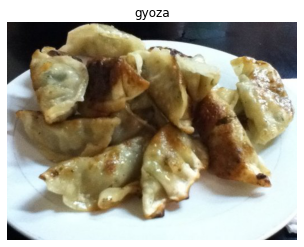

In [16]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/Food_101/train/",
                        target_class=random.choice(class_names))

Let's use the `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [17]:
# Setup data inputs
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                  image_size=IMG_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              shuffle=False) # don't shuffle test data for prediction analysis

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis                                                            

Found 80800 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 5050 files belonging to 101 classes.


## Train a big model with transfer learning on 101 food classes

Here are the step's we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our wn output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validat on 15% of the test data, to save epoch time)


Let's start by creating the `ModelCheckpoint` callback.

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [31]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        moniter="val_accuracy",
                                                        save_best_only=True)

In [32]:
# Import some tensorflow liberaries to make or model looks nice
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.


In [33]:
# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

 We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using `tf.keras.applications.EfficientNetB0` as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a `Dense` layer.

In [34]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)
     

Model created. Let's inspect it.

In [35]:
# Get a summary of our model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

Looking good! Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_laye`r which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model (`EfficientNetb0`) frozen whilst allowing the model to tune its outputs to our custom data.

Time to compile and fit.

In [36]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes = model.fit(train_data,
                                epochs=5, # fit for 5 epochs to keep experiments quick
                                validation_data=val_data,
                                validation_steps=int(0.15 * len(val_data)), # evaluate on smaller portion of validation data
                                callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
2525/2525 [==============================] - 524s 202ms/step - loss: 2.0007 - accuracy: 0.5146 - val_loss: 1.4976 - val_accuracy: 0.6105
Epoch 2/5
2525/2525 [==============================] - 363s 144ms/step - loss: 1.5307 - accuracy: 0.6080 - val_loss: 1.4203 - val_accuracy: 0.6298
Epoch 3/5
2525/2525 [==============================] - 316s 125ms/step - loss: 1.4103 - accuracy: 0.6339 - val_loss: 1.4018 - val_accuracy: 0.6290
Epoch 4/5
2525/2525 [==============================] - 299s 118ms/step - loss: 1.3368 - accuracy: 0.6513 - val_loss: 1.3780 - val_accuracy: 0.6400
Epoch 5/5
2525/2525 [==============================] - 288s 114ms/step - loss: 1.2908 - accuracy: 0.6599 - val_loss: 1.3892 - val_accuracy: 0.6334


It looks like our model is getting some impressive results, but remember, during training our model only evaluated on 15% of the validation data. Let's see how it did on the whole validation dataset.

In [37]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(val_data)
results_feature_extraction_model

474/474 [==============================] - 43s 90ms/step - loss: 1.3328 - accuracy: 0.6516


[1.3327500820159912, 0.6515511274337769]

Well it looks like we just beat our baseline **(the results from the original Food101 paper)!** ... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves look?

In [38]:
# Create a loss curves function
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

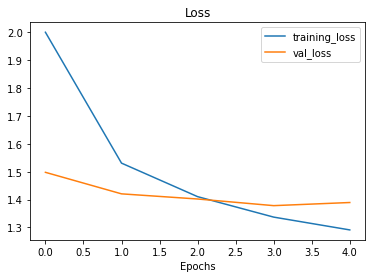

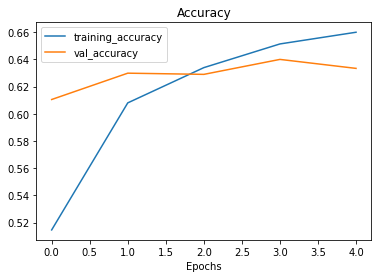

In [39]:
plot_loss_curves(history_all_classes)

**Note:** the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

## Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

we'll refreeze every layer except for the last 5, making them trainable.

In [40]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

In [41]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

Model recompiled, how about we make sure the layers we want are trainable?

In [42]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [43]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 tf.math.truediv_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

Excellent! Time to fine-tune our model.

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [44]:

# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_fine_tune = model.fit(train_data,
                                          epochs=fine_tune_epochs,
                                          validation_data=val_data,
                                          validation_steps=int(0.15 * len(val_data)), # validate on 15% of the validation data
                                          initial_epoch=history_all_classes.epoch[-1]) # start from previous last epoch

Epoch 5/10
2525/2525 [==============================] - 296s 114ms/step - loss: 1.1722 - accuracy: 0.6889 - val_loss: 1.3190 - val_accuracy: 0.6646
Epoch 6/10
2525/2525 [==============================] - 282s 112ms/step - loss: 1.0768 - accuracy: 0.7110 - val_loss: 1.2794 - val_accuracy: 0.6686
Epoch 7/10
2525/2525 [==============================] - 278s 110ms/step - loss: 1.0091 - accuracy: 0.7248 - val_loss: 1.2159 - val_accuracy: 0.6796
Epoch 8/10
2525/2525 [==============================] - 276s 109ms/step - loss: 0.9595 - accuracy: 0.7396 - val_loss: 1.2413 - val_accuracy: 0.6743
Epoch 9/10
2525/2525 [==============================] - 275s 109ms/step - loss: 0.9122 - accuracy: 0.7500 - val_loss: 1.2289 - val_accuracy: 0.6800
Epoch 10/10
2525/2525 [==============================] - 274s 108ms/step - loss: 0.8789 - accuracy: 0.7581 - val_loss: 1.2240 - val_accuracy: 0.6884


Once again, during training we were only evaluating on a small portion of the validation data, let's find out how our model went on all of the validation data.


In [45]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_fine_tune = model.evaluate(val_data)
results_all_classes_fine_tune

474/474 [==============================] - 38s 81ms/step - loss: 1.1948 - accuracy: 0.6923


[1.1948177814483643, 0.6923432350158691]

it seems like our model got a slight boost from fine-tuning.

We might get a better picture by using `compare_historys()` function and seeing what the training curves say.

In [46]:
# Create function to compare history
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

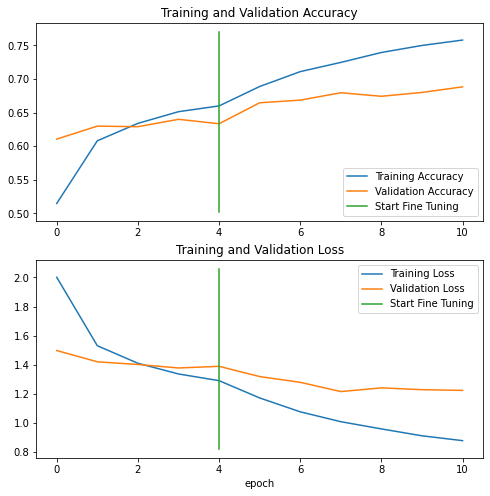

In [47]:
compare_historys(original_history=history_all_classes,
                 new_history=history_all_classes_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on ImageNet which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [48]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/tensorflow/101_food_classes_saved_big_model")

## Evaluating the performance of the big model across all different classes


We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the val dataset.

In [49]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/101_food_classes_saved_big_model")

To make sure our loaded model is indead a trained model, let's evaluate its performance on the valdation dataset.

In [50]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = loaded_model.evaluate(test_data)
loaded_loss, loaded_accuracy
     

158/158 [==============================] - 15s 95ms/step - loss: 1.1539 - accuracy: 0.7026


(1.1538922786712646, 0.7025742530822754)

## Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the predict() method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [51]:
model = loaded_model

In [52]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

158/158 [==============================] - 14s 80ms/step


We just passed all of the test images to our model and asked it to make a prediction on what food it thinks is in each.

In [53]:
# How many predictions are there?
len(pred_probs)

5050

And if each image could be one of 101 classes, how many predictions do you think we'll have for each image?

In [54]:
# What's the shape of our predictions?
pred_probs.shape

(5050, 101)

What we've got is often referred to as a predictions probability tensor (or array).

Let's see what the first 10 look like.

In [55]:
# How do they look?
pred_probs[:10]

array([[4.1356122e-01, 1.4287495e-03, 1.3706368e-01, ..., 2.4048537e-04,
        7.3999510e-04, 7.8890128e-03],
       [1.1020093e-01, 6.9511916e-05, 8.4615403e-01, ..., 3.2573957e-05,
        6.0146591e-05, 1.3138469e-05],
       [5.2545679e-01, 2.9142736e-06, 1.0712091e-04, ..., 2.1409712e-04,
        3.4884978e-04, 2.8515197e-04],
       ...,
       [8.6255413e-01, 1.2389054e-07, 2.1410431e-03, ..., 1.8580395e-03,
        3.3895155e-06, 7.7760378e-05],
       [4.0053183e-01, 8.7693341e-05, 3.5741370e-02, ..., 1.2579737e-03,
        5.2000028e-06, 2.5013085e-03],
       [8.7879068e-01, 2.6875300e-06, 9.2679210e-04, ..., 2.7669717e-03,
        2.2063630e-06, 4.0296669e-05]], dtype=float32)

Alright, it seems like we've got a bunch of tensors of really small numbers, how about we zoom into one of them?

In [56]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [4.13561225e-01 1.42874953e-03 1.37063682e-01 6.14300603e-04
 1.65726538e-04 4.19809110e-03 4.09170534e-05 1.02344737e-03
 6.26102686e-02 7.83546348e-05 3.32057034e-03 8.38564301e-04
 3.91605077e-04 1.52695757e-05 9.51900706e-03 5.06112468e-04
 1.54168217e-03 7.40691693e-03 2.42271912e-04 2.38943408e-04
 9.51289607e-04 4.77528054e-04 1.02726580e-03 3.45947873e-03
 6.65623111e-06 4.55585905e-05 2.62927606e-05 3.75026633e-04
 2.80544918e-04 9.69013013e-03 9.89463442e-05 9.03343316e-04
 7.84699441e-05 3.95281568e-05 6.21678773e-04 7.27991015e-03
 1.64395351e-05 1.19036740e-04 1.30918625e-05 1.99024100e-03
 1.03088380e-04 9.83231585e-05 2.98867747e-03 9.28608119e-04
 1.67258200e-03 4.41158136e-07 2.12624576e-03 1.05913103e-01
 2.40078384e-06 7.55617802e-04 3.46741918e-03 1.12989114e-03
 3.93093638e-02 4.67819162e-04 3.23378714e-07 1.02525472e-03
 1.00956450e-03 1.47747720e-04 1.07950000e-

For each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

We can find the index of the maximum value in each prediction probability tensor using the argmax() method.

In [57]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 2, 0, 0, 0, 0, 2, 0, 8, 0])

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data `object (which is in the form of a `tf.data.Dataset`) using the `unbatch()` method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

In [58]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since `test_dat`a isn't shuffled, the y_labels array comes back in the same order as the `pred_classes` array.

The final check is to see how many labels we've got.

In [59]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)


5050

As expected, the number of labels matches the number of images we've got. Time to compare our model's predictions with the ground truth labels.

## Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's `accuracy_score()` function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.


In [60]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.7025742574257425

In [61]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: -4.343467141509905e-09


Okay, it looks like our `pred_classes` array and `y_labels` arrays are in the right orders.

How about we get a little bit more visual with a confusion matrix?

To do so, we'll use our `make_confusion_matrix` function.

In [62]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
     

Right now our predictions and truth labels are in the form of integers, however, they'll be much easier to understand if we get their actual names. We can do so using the `class_names` attribute on our `test_data` object.

In [63]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

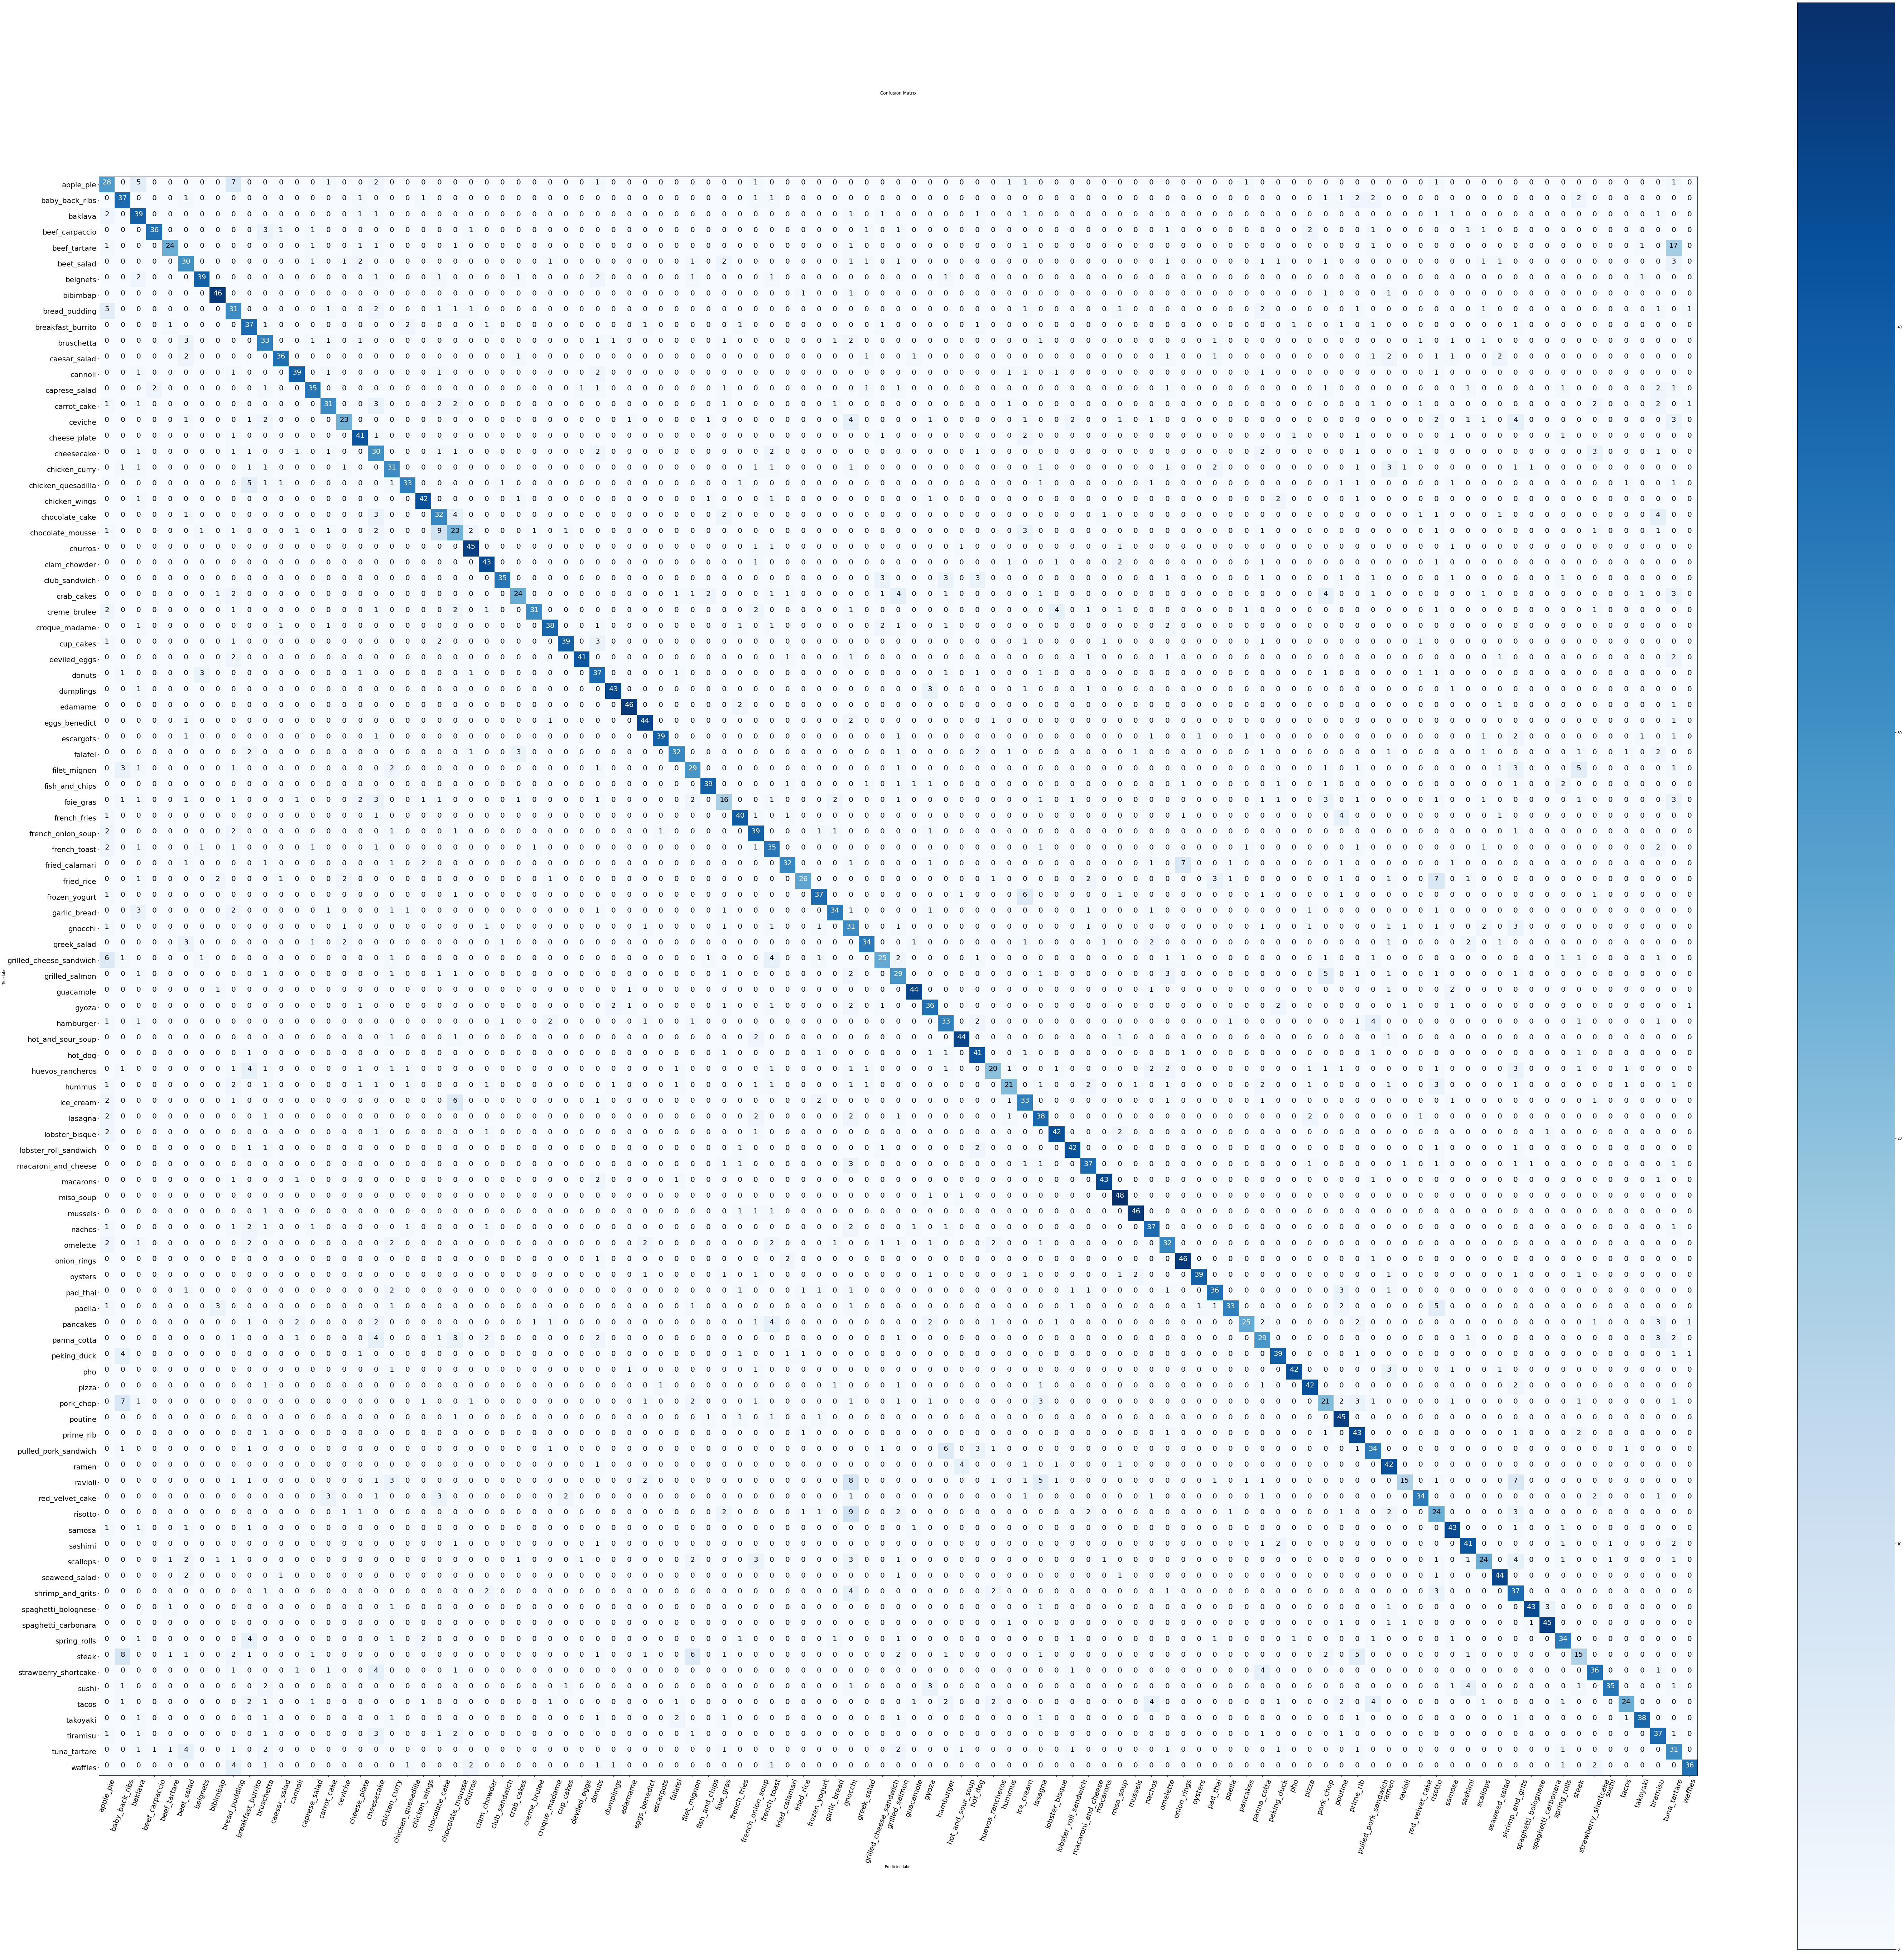

In [64]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

Now that's a big confusion matrix. It may look a little daunting at first but after zooming in a little, we can see how it gives us insight into which classes its getting "confused" on.

The good news is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's `classification_report()` function.

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.41      0.56      0.47        50
           1       0.55      0.74      0.63        50
           2       0.57      0.78      0.66        50
           3       0.92      0.72      0.81        50
           4       0.83      0.48      0.61        50
           5       0.54      0.60      0.57        50
           6       0.87      0.78      0.82        50
           7       0.85      0.92      0.88        50
           8       0.43      0.62      0.51        50
           9       0.54      0.74      0.63        50
          10       0.54      0.66      0.59        50
          11       0.88      0.72      0.79        50
          12       0.83      0.78      0.80        50
          13       0.80      0.70      0.74        50
          14       0.72      0.62      0.67        50
          15       0.74      0.46      0.57        50
          16       0.75      0.82      0.78        50
          17       0.43    

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:

* Precision - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* F1 score - Combines precision and recall into one metric. 1 is best, 0 is worst.
The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting output_dict=True.

In [66]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.4117647058823529,
  'recall': 0.56,
  'f1-score': 0.4745762711864407,
  'support': 50},
 '1': {'precision': 0.5522388059701493,
  'recall': 0.74,
  'f1-score': 0.6324786324786325,
  'support': 50},
 '2': {'precision': 0.5652173913043478,
  'recall': 0.78,
  'f1-score': 0.6554621848739495,
  'support': 50},
 '3': {'precision': 0.9230769230769231,
  'recall': 0.72,
  'f1-score': 0.8089887640449438,
  'support': 50},
 '4': {'precision': 0.8275862068965517,
  'recall': 0.48,
  'f1-score': 0.6075949367088608,
  'support': 50},
 '5': {'precision': 0.5357142857142857,
  'recall': 0.6,
  'f1-score': 0.5660377358490566,
  'support': 50},
 '6': {'precision': 0.8666666666666667,
  'recall': 0.78,
  'f1-score': 0.8210526315789474,
  'support': 50},
 '7': {'precision': 0.8518518518518519,
  'recall': 0.92,
  'f1-score': 0.8846153846153846,
  'support': 50},
 '8': {'precision': 0.4305555555555556,
  'recall': 0.62,
  'f1-score': 0.5081967213114755,
  'support': 50},
 '9': {'pre

Alright, there's still a fair few values here, how about we narrow down?

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called class_f1_scores and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [67]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.4745762711864407,
 'baby_back_ribs': 0.6324786324786325,
 'baklava': 0.6554621848739495,
 'beef_carpaccio': 0.8089887640449438,
 'beef_tartare': 0.6075949367088608,
 'beet_salad': 0.5660377358490566,
 'beignets': 0.8210526315789474,
 'bibimbap': 0.8846153846153846,
 'bread_pudding': 0.5081967213114755,
 'breakfast_burrito': 0.6271186440677965,
 'bruschetta': 0.5945945945945946,
 'caesar_salad': 0.7912087912087912,
 'cannoli': 0.8041237113402062,
 'caprese_salad': 0.7446808510638298,
 'carrot_cake': 0.6666666666666666,
 'ceviche': 0.5679012345679013,
 'cheese_plate': 0.780952380952381,
 'cheesecake': 0.5,
 'chicken_curry': 0.6019417475728155,
 'chicken_quesadilla': 0.7333333333333334,
 'chicken_wings': 0.8399999999999999,
 'chocolate_cake': 0.6037735849056605,
 'chocolate_mousse': 0.4509803921568628,
 'churros': 0.8653846153846153,
 'clam_chowder': 0.8349514563106797,
 'club_sandwich': 0.7954545454545453,
 'crab_cakes': 0.5853658536585366,
 'creme_brulee': 0.738095238095

Looking good!

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion?

In [68]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33              edamame  0.920000
65              mussels  0.920000
91  spaghetti_carbonara  0.909091
90  spaghetti_bolognese  0.895833
63             macarons  0.886598
..                  ...       ...
77            pork_chop  0.442105
82              ravioli  0.428571
84              risotto  0.424779
39            foie_gras  0.376471
93                steak  0.361446

[101 rows x 2 columns]

Now we're talking! Let's finish it off with a nice horizontal bar chart.

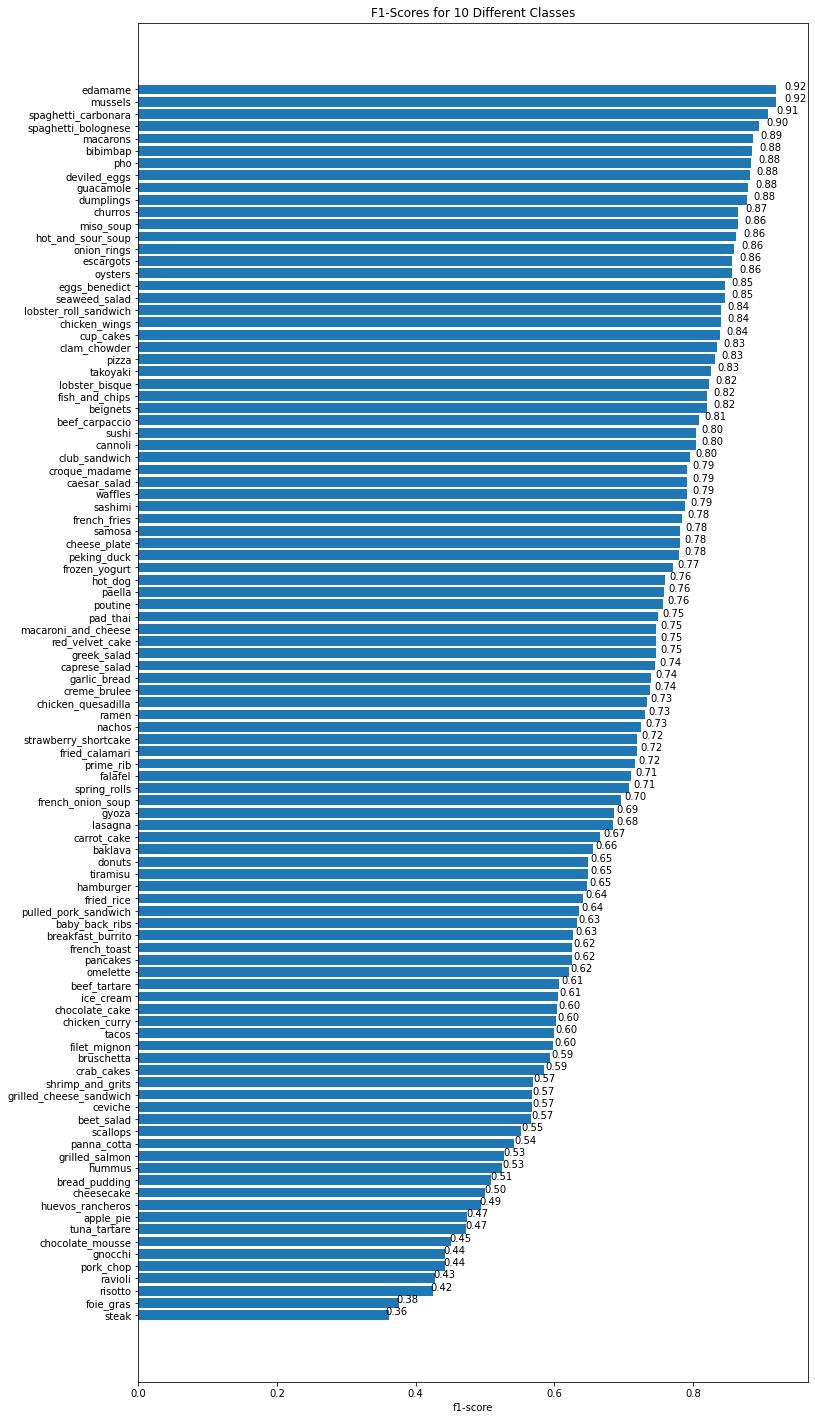

In [69]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Now that's a good looking graph! I mean, the text positioning could be improved a little but it'll do for now.

Can you see how visualizing our model's predictions gives us a completely new insight into its performance?

A few moments ago we only had an accuracy score but now we've got an indiciation of how well our model is performing on a class by class basis.

It seems like our model performs fairly poorly on classes like `apple_pie` and `ravioli` while for classes like `edamame` and `pho` the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

## Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:

* Read in a target image filepath using `tf.io.read_file()`.
* Turn the image into a `Tensor` using `tf.io.decode_image()`.
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using `tf.image.resize()`.
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [74]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (150, 150, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

mage loading and preprocessing function ready.

Now let's write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 [==============================] - 0s 29ms/step


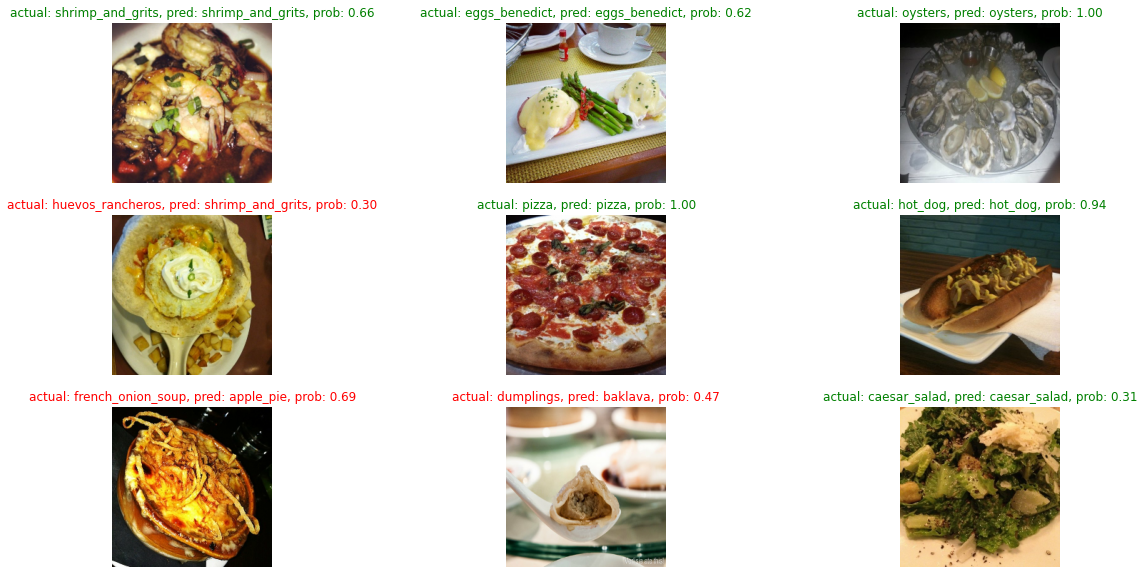

In [76]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20, 10))
for i in range(9):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

After going through enough random samples, it starts to become clear that the model tends to make far worse predictions on classes which are visually similar such as `baby_back_ribs` getting mistaken as `steak` and `vice versa`.

## Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
* **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [80]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("/content/Food_101/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/Food_101/test/apple_pie/1034399.jpg',
 b'/content/Food_101/test/apple_pie/1106961.jpg',
 b'/content/Food_101/test/apple_pie/1111062.jpg',
 b'/content/Food_101/test/apple_pie/1113017.jpg',
 b'/content/Food_101/test/apple_pie/112378.jpg',
 b'/content/Food_101/test/apple_pie/1327259.jpg',
 b'/content/Food_101/test/apple_pie/1344873.jpg',
 b'/content/Food_101/test/apple_pie/1364847.jpg',
 b'/content/Food_101/test/apple_pie/1410907.jpg',
 b'/content/Food_101/test/apple_pie/1498817.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

* Their ground truth labels (y_labels).
* The class the model predicted (pred_classes).
* The maximum prediction probabilitity value (pred_probs.max(axis=1)).
* The ground truth class names.
* The predicted class names.

In [81]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  pred_conf  \
0  b'/content/Food_101/test/apple_pie/1034399.jpg'       0       0   0.413561   
1  b'/content/Food_101/test/apple_pie/1106961.jpg'       0       2   0.846154   
2  b'/content/Food_101/test/apple_pie/1111062.jpg'       0       0   0.525457   
3  b'/content/Food_101/test/apple_pie/1113017.jpg'       0       0   0.525193   
4   b'/content/Food_101/test/apple_pie/112378.jpg'       0       0   0.682107   

  y_true_classname y_pred_classname  
0        apple_pie        apple_pie  
1        apple_pie          baklava  
2        apple_pie        apple_pie  
3        apple_pie        apple_pie  
4        apple_pie        apple_pie

Nice! How about we make a simple column telling us whether or not the prediction is right or wrong?

In [82]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  pred_conf  \
0  b'/content/Food_101/test/apple_pie/1034399.jpg'       0       0   0.413561   
1  b'/content/Food_101/test/apple_pie/1106961.jpg'       0       2   0.846154   
2  b'/content/Food_101/test/apple_pie/1111062.jpg'       0       0   0.525457   
3  b'/content/Food_101/test/apple_pie/1113017.jpg'       0       0   0.525193   
4   b'/content/Food_101/test/apple_pie/112378.jpg'       0       0   0.682107   

  y_true_classname y_pred_classname  pred_correct  
0        apple_pie        apple_pie          True  
1        apple_pie          baklava         False  
2        apple_pie        apple_pie          True  
3        apple_pie        apple_pie          True  
4        apple_pie        apple_pie          True

And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [83]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
4151  b'/content/Food_101/test/red_velvet_cake/11051...      83      29   
3455      b'/content/Food_101/test/oysters/1404187.jpg'      69      65   
4664        b'/content/Food_101/test/steak/1849463.jpg'      93      79   
1102  b'/content/Food_101/test/chocolate_mousse/1142...      22      21   
4537  b'/content/Food_101/test/spaghetti_bolognese/3...      90      91   
4587  b'/content/Food_101/test/spaghetti_carbonara/3...      91      90   
3663  b'/content/Food_101/test/panna_cotta/1747250.jpg'      73      86   
5020      b'/content/Food_101/test/waffles/1941638.jpg'     100      23   
2267  b'/content/Food_101/test/frozen_yogurt/1806964...      45      58   
3602     b'/content/Food_101/test/pancakes/1105032.jpg'      72      27   
4900     b'/content/Food_101/test/tiramisu/1026043.jpg'      98      78   
2225   b'/content/Food_101/test/fried_rice/2583764.jpg'      44       7   
4061        b'/content/Food_101/test/ramen/1570023.jpg'      81      54   
2860       b'/content/Food_101/test/hummus/1671193.jpg'      57      65   
1852  b'/content/Food_101/test/filet_mignon/1090035....      37      79   
1410  b'/content/Food_101/test/croque_madame/1497430...      28       2   
2213   b'/content/Food_101/test/fried_rice/1727509.jpg'      44      84   
2262  b'/content/Food_101/test/frozen_yogurt/1703335...      45      58   
3080  b'/content/Food_101/test/lobster_roll_sandwich...      61      89   
3743   b'/content/Food_101/test/peking_duck/444663.jpg'      74       1   

      pred_conf       y_true_classname     y_pred_classname  pred_correct  
4151   0.999981        red_velvet_cake            cup_cakes         False  
3455   0.999976                oysters              mussels         False  
4664   0.999948                  steak            prime_rib         False  
1102   0.999932       chocolate_mousse       chocolate_cake         False  
4537   0.999394    spaghetti_bolognese  spaghetti_carbonara         False  
4587   0.999361    spaghetti_carbonara  spaghetti_bolognese         False  
3663   0.997864            panna_cotta              sashimi         False  
5020   0.997784                waffles              churros         False  
2267   0.996903          frozen_yogurt            ice_cream         False  
3602   0.996542               pancakes         creme_brulee         False  
4900   0.996352               tiramisu              poutine         False  
2225   0.995615             fried_rice             bibimbap         False  
4061   0.995042                  ramen    hot_and_sour_soup         False  
2860   0.992744                 hummus              mussels         False  
1852   0.992006           filet_mignon            prime_rib         False  
1410   0.988509          croque_madame              baklava         False  
2213   0.987716             fried_rice              risotto         False  
2262   0.987467          frozen_yogurt            ice_cream         False  
3080   0.987376  lobster_roll_sandwich     shrimp_and_grits         False  
3743   0.986784            peking_duck       baby_back_ribs         False

Very interesting... just by comparing the ground truth classname (`y_true_classname`) and the prediction classname column (`y_pred_classname`), do you notice any trends?

It might be easier if we visualize them.

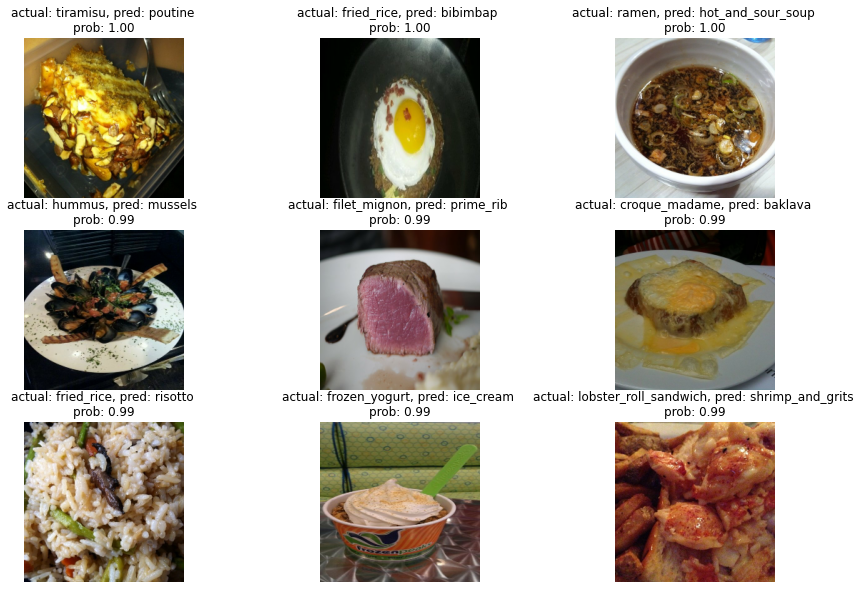

In [84]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:

* Some of the labels might be wrong - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as active learning.
* Could more samples be collected? - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the model oncustom images of food

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

In [85]:
# Create unzip data function
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [86]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2023-01-05 11:49:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  5.26MB/s    in 2.4s    

2023-01-05 11:49:11 (5.26 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



Wonderful, we can load these in and turn them into tensors using our `load_and_prep_image()` function but first we need a list of image filepaths.

In [87]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg']

Now we can use similar code to what we used previously to load in our images, make a prediction on each using our trained model and then plot the image along with the predicted class.

1/1 [==============================] - 0s 26ms/step


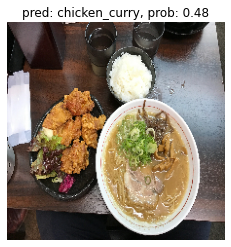

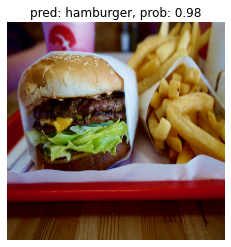

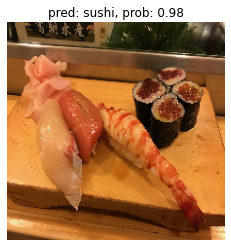

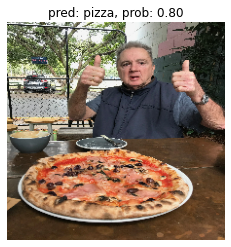

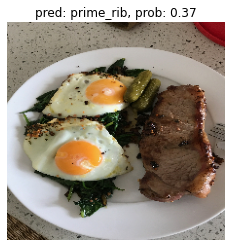

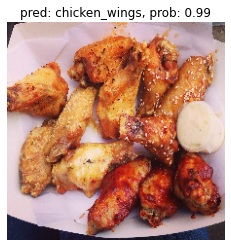

In [88]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

How cool is that?! Our Food Vision model has come to life!